# **RNN Introduction**


## Importing required libraries


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
import math
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras import layers
from keras.callbacks import ModelCheckpoint, EarlyStopping
import random
import seaborn as sns
import datetime as dt

## Loading and preprocessing the data
### Dataset 4-Deep learning/5-Time Series Forecasting (RNN)/LAB/ٌDatasets/traffic.csv

In [2]:
df = pd.read_csv('D:\\Tuwaiq Academy\\Tuwaiq_Academy_T5_Week_5\\Week5LAB1\\Datasets\\traffic.csv')
df.head()

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


In [3]:
df.dtypes

DateTime    object
Junction     int64
Vehicles     int64
ID           int64
dtype: object

In [4]:
df['DateTime'] = pd.to_datetime(df['DateTime'])
df.dtypes

DateTime    datetime64[ns]
Junction             int64
Vehicles             int64
ID                   int64
dtype: object

In [5]:
df.head()

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


In [6]:
df.drop('ID', inplace=True, axis=1)
df.head()

,DateTime,Junction,Vehicles
0,2015-11-01 00:00:00,1,15
1,2015-11-01 01:00:00,1,13
2,2015-11-01 02:00:00,1,10
3,2015-11-01 03:00:00,1,7
4,2015-11-01 04:00:00,1,9


In [7]:
df['Junction'].value_counts()

Junction
1    14592
2    14592
3    14592
4     4344
Name: count, dtype: int64

In [8]:
df.shape

(48120, 3)

In [9]:
df['Vehicles'].unique()

array([ 15,  13,  10,   7,   9,   6,   8,  11,  12,  17,  16,  20,  19,
        14,  22,  32,  31,  35,  26,  34,  30,  27,  24,  29,  21,  18,
        33,  28,  25,  23,  40,  38,  36,  48,  43,  41,  37,  39,  42,
        44,  47,  50,  45,  46,  70,  54,  52,  55,  49,  58,  64,  62,
        51,  53,  61,  56,  57,  63,  59,  60,  67,  76,  79,  66,  65,
        68,  69,  86,  73,  77,  74,  71,  72,  78,   5,  81,  75,  80,
        82,  89,  83,  93,  91,  85,  90,  84,  87,  94,  92, 106,  98,
        88,  96, 120,  97, 104,  95, 100, 112, 103, 105, 143, 134, 135,
       141, 156, 110, 102,  99, 132, 124, 113, 109, 115, 101, 108, 114,
       107, 111, 136, 129, 118, 116, 123, 133, 128, 117, 121, 127, 140,
       126, 122, 119,   2,   4,   3,   1, 125, 180, 173, 162], dtype=int64)

In [10]:
df['Vehicles'].describe()

count    48120.000000
mean        22.791334
std         20.750063
min          1.000000
25%          9.000000
50%         15.000000
75%         29.000000
max        180.000000
Name: Vehicles, dtype: float64

In [11]:
df['DateTime'].describe()

count                            48120
mean     2016-09-19 06:03:56.109725696
min                2015-11-01 00:00:00
25%                2016-04-16 01:45:00
50%                2016-09-30 03:30:00
75%                2017-02-25 16:00:00
max                2017-06-30 23:00:00
Name: DateTime, dtype: object

In [12]:
def specific_data(junction, start, end):
    junction_data = df[df['Junction'] == junction]
    date_filtered_data = junction_data[(junction_data['DateTime'] > start) & (junction_data['DateTime'] < end)]
    return date_filtered_data

In [13]:

junction_number = random.choice(df['Junction'].unique().tolist())

start_date=dt.datetime(2015,11,1)
end_date=dt.datetime(2017,6,30)


specific_df = specific_data(junction_number, start_date, end_date)

In [14]:
specific_df.head()

,DateTime,Junction,Vehicles
1,2015-11-01 01:00:00,1,13
2,2015-11-01 02:00:00,1,10
3,2015-11-01 03:00:00,1,7
4,2015-11-01 04:00:00,1,9
5,2015-11-01 05:00:00,1,6


In [15]:
specific_df.shape

(14567, 3)

## Visualization

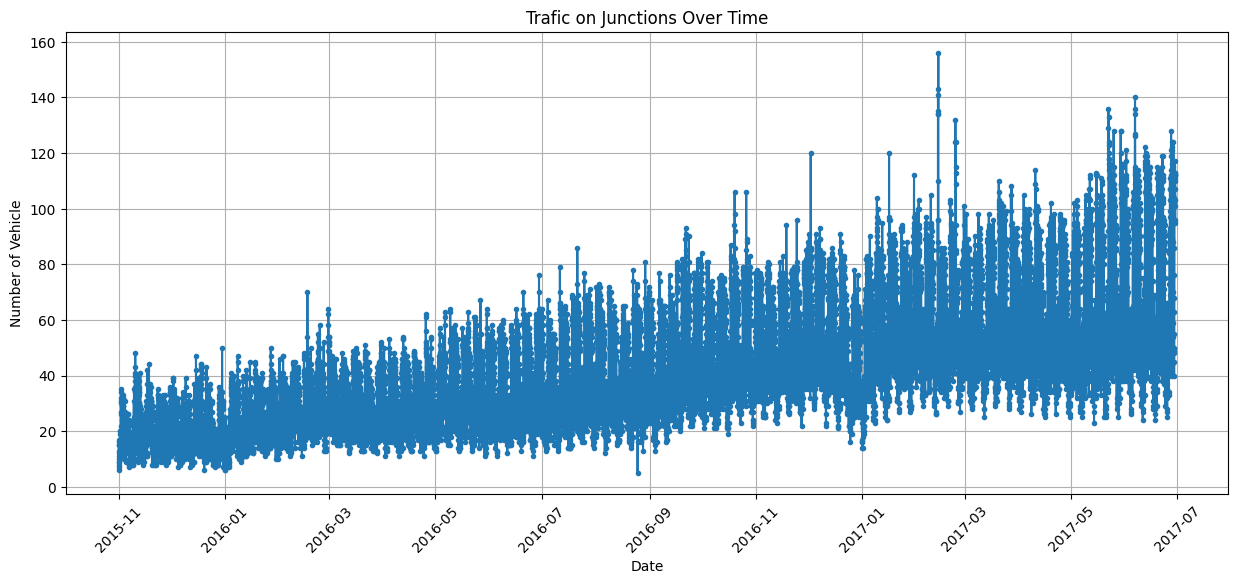

In [16]:
specific_df['DateTime'] = pd.to_datetime(specific_df['DateTime'])

plt.figure(figsize=(15,6))
plt.plot(specific_df['DateTime'], specific_df['Vehicles'], marker='.')
plt.title('Trafic on Junctions Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Vehicle')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

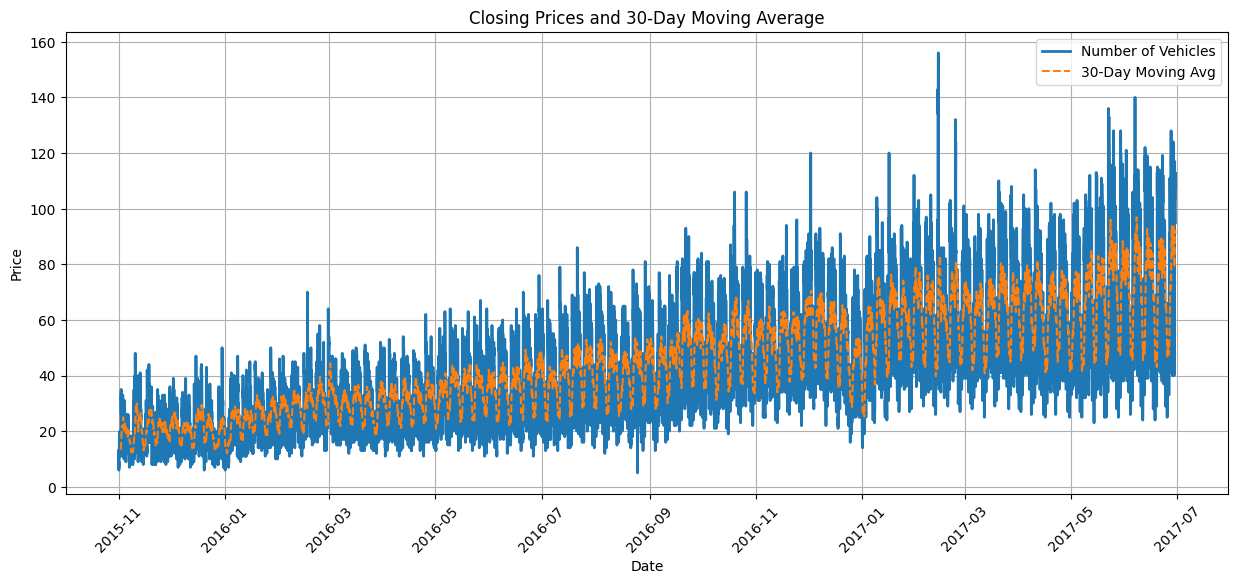

In [17]:
window = 30
plt.figure(figsize=(15, 6))
plt.plot(specific_df['DateTime'], specific_df['Vehicles'], label='Number of Vehicles', linewidth=2)
plt.plot(specific_df['DateTime'], specific_df['Vehicles'].rolling(window=window).mean(), label=f'{window}-Day Moving Avg', linestyle='--')
plt.title(f'Closing Prices and {window}-Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

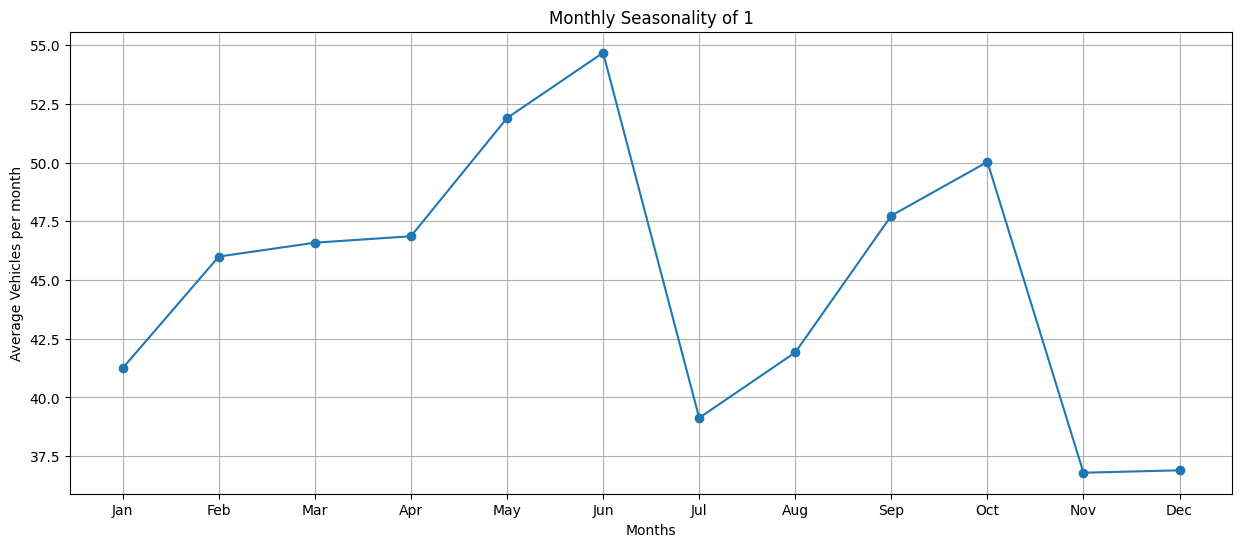

In [18]:
specific_df['Month'] = specific_df['DateTime'].dt.month

monthly_average = specific_df.groupby('Month')['Vehicles'].mean()

plt.figure(figsize=(15, 6))
plt.plot(monthly_average.index, monthly_average.values, marker='o')
plt.title(f'Monthly Seasonality of {junction_number}')
plt.xlabel('Months')
plt.ylabel('Average Vehicles per month')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.show()

In [19]:
new_df = specific_df.reset_index()['Vehicles']

In [20]:
new_df

0         13
1         10
2          7
3          9
4          6
        ... 
14562    113
14563    110
14564    101
14565     96
14566     95
Name: Vehicles, Length: 14567, dtype: int64

In [21]:
scaler = MinMaxScaler()
scaled_df=scaler.fit_transform(np.array(new_df).reshape(-1,1))

In [22]:
scaled_df.shape

(14567, 1)

## Split the data into train and test

In [23]:
train_size = int(len(scaled_df) * 0.8)
train_size

11653

In [24]:
scaled_df.shape

(14567, 1)

In [25]:
train_data, test_data = scaled_df[:train_size], scaled_df[train_size:]

In [26]:
n_past = 60


X_train, y_train = [], []
for i in range(n_past, len(train_data)):
    X_train.append(train_data[i - n_past:i, 0])
    y_train.append(train_data[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)


X_test, y_test = [], []
for i in range(n_past, len(test_data)):
    X_test.append(test_data[i - n_past:i, 0])
    y_test.append(test_data[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)

In [27]:
print("Training set size:-")
print(X_train.shape), print(y_train.shape)
print("\n")
print("Testing set size:-")
print(X_test.shape), print(y_test.shape)

Training set size:-
(11593, 60)
(11593,)


Testing set size:-
(2854, 60)
(2854,)


(None, None)

In [28]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])

## Modeling


In [52]:

model = Sequential([
    layers.SimpleRNN(units=100, return_sequences=True, input_shape=(X_train.shape[1],1)),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.SimpleRNN(units=100, return_sequences=True),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.SimpleRNN(units=50),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(units=1),
])

model.summary()

C:\Users\abo_O\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_9 (SimpleRNN)        │ (None, 60, 100)        │        10,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 60, 100)        │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_10 (SimpleRNN)       │ (None, 60, 100)        │        20,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 60, 100)        │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_11 (SimpleRNN)       │ (None, 50)             │         7,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 50)             │           200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,901 (151.96 KB)

 Trainable params: 38,401 (150.00 KB)

 Non-trainable params: 500 (1.95 KB)

In [53]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [54]:
checkpoint = ModelCheckpoint(filepath='weight.keras', save_best_only= True)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model.fit(X_train, y_train,
          validation_data=(X_test, y_test),
          epochs= 30,
          batch_size=32,
          verbose=1,
          callbacks=[checkpoint, early_stopping])

Epoch 1/30
363/363 ━━━━━━━━━━━━━━━━━━━━ 23s 47ms/step - loss: 1.2512 - val_loss: 0.0261
Epoch 2/30
363/363 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - loss: 0.1851 - val_loss: 0.0199
Epoch 3/30
363/363 ━━━━━━━━━━━━━━━━━━━━ 16s 43ms/step - loss: 0.0463 - val_loss: 0.0134
Epoch 4/30
363/363 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - loss: 0.0139 - val_loss: 0.0096
Epoch 5/30
363/363 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - loss: 0.0054 - val_loss: 0.0066
Epoch 6/30
363/363 ━━━━━━━━━━━━━━━━━━━━ 19s 51ms/step - loss: 0.0037 - val_loss: 0.0058
Epoch 7/30
363/363 ━━━━━━━━━━━━━━━━━━━━ 19s 51ms/step - loss: 0.0032 - val_loss: 0.0064
Epoch 8/30
363/363 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - loss: 0.0029 - val_loss: 0.0044
Epoch 9/30
363/363 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - loss: 0.0030 - val_loss: 0.0052
Epoch 10/30
363/363 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - loss: 0.0030 - val_loss: 0.0043
Epoch 11/30
363/363 ━━━━━━━━━━━━━━━━━━━━ 14s 39ms/step - loss: 0.0028 - val_loss: 0.0053
Epoch 12/30
363/363 ━━━━━━━━━━

In [55]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

363/363 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


In [56]:
# Check the shape of train_predict and test_predict
print("train_predict shape:", train_predict.shape)
print("test_predict shape:", test_predict.shape)

train_predict shape: (11593, 1)
test_predict shape: (2854, 1)


In [49]:

# Reshape if necessary. Assuming predictions are in the shape (samples, time_steps, features)
if len(train_predict.shape) == 3:
    train_predict = train_predict[:, -1, :]  # Take the last time step prediction if needed
if len(test_predict.shape) == 3:
    test_predict = test_predict[:, -1, :]  # Take the last time step prediction if needed

# Ensure the predictions are 2D before inverse_transform
train_predict_2d = train_predict.reshape(-1, 1)
test_predict_2d = test_predict.reshape(-1, 1)

# Inverse transform
train_predict = scaler.inverse_transform(train_predict_2d)
test_predict = scaler.inverse_transform(test_predict_2d)


In [48]:
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

ValueError: Found array with dim 3. None expected <= 2.

In [50]:
print(math.sqrt(mean_squared_error(y_train,train_predict)))
print(math.sqrt(mean_squared_error(y_test,test_predict)))

39.99680156778342
39.81208952136855


## Visualization of results


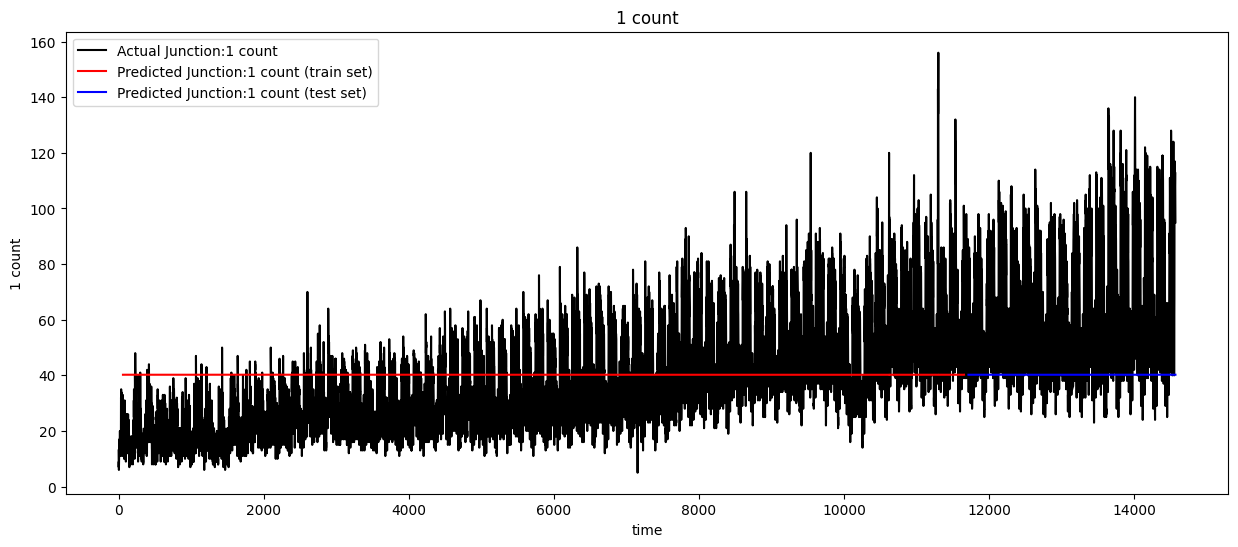

In [51]:

look_back = 60

# Ensure the arrays are of type float
trainPredPlot = np.empty_like(new_df, dtype=float)
trainPredPlot[:] = np.nan

trainPredPlot[look_back:len(train_predict)+look_back] = train_predict.flatten()

testPredictPlot = np.empty_like(new_df, dtype=float)
testPredictPlot[:] = np.nan

test_start = len(new_df) - len(test_predict)
testPredictPlot[test_start:] = test_predict.flatten()

original_scaled_data = scaler.inverse_transform(scaled_df)

plt.figure(figsize=(15, 6))
plt.plot(original_scaled_data, color='black', label=f"Actual Junction:{junction_number} count")
plt.plot(trainPredPlot, color='red', label=f"Predicted Junction:{junction_number} count (train set)")
plt.plot(testPredictPlot, color='blue', label=f"Predicted Junction:{junction_number} count (test set)")

plt.title(f"{junction_number} count")
plt.xlabel("time")
plt.ylabel(f"{junction_number} count")
plt.legend()
plt.show()


In [38]:
# To predict for the next 10 days, you'll need the last n_past days of data
last_sequence = X_test[-1]

# Reshape the last_sequence to match the input shape of the model
last_sequence = last_sequence.reshape(1, n_past, 1)

# Generate predictions for the next 10 days
predictions_next_10_days = []
for _ in range(10):  # Predicting for the next 10 days
    next_day_prediction = model.predict(last_sequence)
    scalar_prediction = next_day_prediction[0, 0]  # Extract the scalar value
    predictions_next_10_days.append(scalar_prediction)  # Get the predicted value
    last_sequence = np.roll(last_sequence, -1, axis=1)  # Shift the sequence by one day
    last_sequence[0, -1, 0] = scalar_prediction  # Update the last element with the new prediction

# Transform the predictions back to the original scale
predictions_next_10_days = scaler.inverse_transform(np.array(predictions_next_10_days).reshape(-1, 1))

# Print the predictions for the next 10 days
print("Predictions for the next 10 days:")
for i, prediction in enumerate(predictions_next_10_days, start=1):
    print(f"Day {i}: Predicted Count = {prediction[0]}")


ValueError: Exception encountered when calling Sequential.call().

[1mCannot take the length of shape with unknown rank.[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=<unknown>, dtype=float32)
  • training=False
  • mask=None

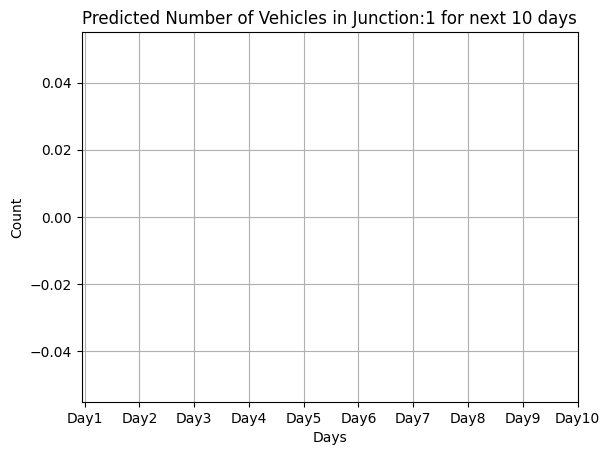

In [39]:
plt.plot(predictions_next_10_days, marker='*')
plt.title(f'Predicted Number of Vehicles in Junction:{junction_number} for next 10 days')
plt.xlabel('Days')
plt.ylabel('Count')
plt.xticks(range(0, 10), ['Day1', 'Day2', 'Day3', 'Day4', 'Day5', 'Day6', 'Day7', 'Day8', 'Day9', 'Day10'])
plt.grid(True)
plt.show()